In [153]:
from pyuvdata.uvdata.mir_parser import MirParser
import numpy as np
import matplotlib.pyplot as plt
from ozone import Ozone
from load_ac import stack_antenna_ac


In [55]:
mir_data = MirParser("/Users/gkeating/data/SMA/ozone/211009_04:56:19", has_auto=True)
ozone_model = Ozone('/Users/gkeating/newdata/')
pwv = 2

In [160]:
freqs, stacked, spw_num, elevation = stack_antenna_ac(mir_data, antenna_num=1, rx_num=0, normalization=False, return_el=True, spw_baselining=False, mad_dev=10.0)

In [57]:
model_arr = np.vstack([np.interp(freqs, ozone_model.data['freq']['map'], ozone_model(pwv=pwv, zenith=np.radians(90-val))[0][0, 0]) for val in elevation])

In [175]:
old_stack = stacked * 1
tsys = 200
new_stack = stacked / (model_arr+tsys)

In [176]:
for item in [old_stack, new_stack]:
    item /= np.repeat(np.nanmedian(item,axis=0).reshape([1,-1]), item.shape[0], axis=0)
    item /= np.repeat(np.nanmedian(item,axis=1).reshape([-1,1]), item.shape[1], axis=1)

/var/folders/6k/9m18n_s947n5ts95gb8v5v180000gn/T/ipykernel_34564/22747027.py:2: RuntimeWarning: All-NaN slice encountered
  item /= np.repeat(np.nanmedian(item,axis=0).reshape([1,-1]), item.shape[0], axis=0)


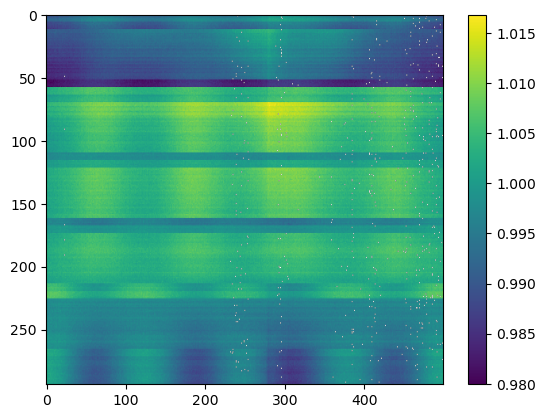

In [177]:
plt.imshow(old_stack[:, 46250:46750], aspect='auto')
# plt.clim(0.975, 1.025)
plt.colorbar()

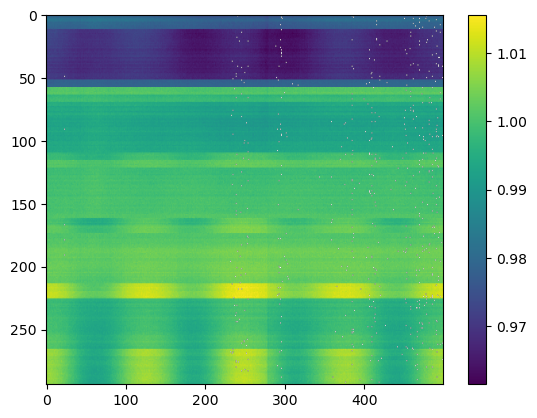

In [179]:
plt.imshow(new_stack[:, 46250:46750], aspect='auto')
#plt.clim(0.975, 1.025)
#plt.xlim([46250, 46750])
plt.colorbar()

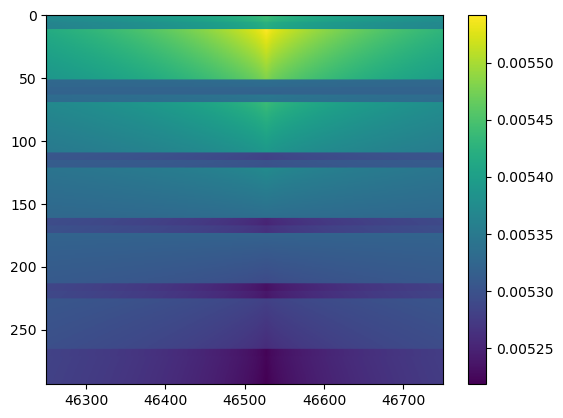

In [165]:
plt.imshow(((model_arr + tsys)/ np.median(model_arr + tsys, axis=1)[:, None])/ np.median(model_arr + tsys, axis=0), aspect='auto')
plt.xlim([46250, 46750])
plt.colorbar()

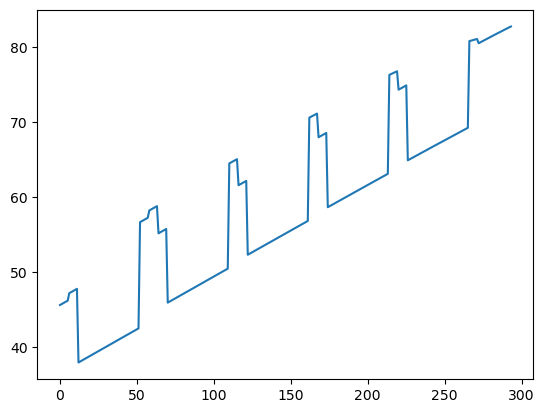

In [76]:
plt.plot(elevation)

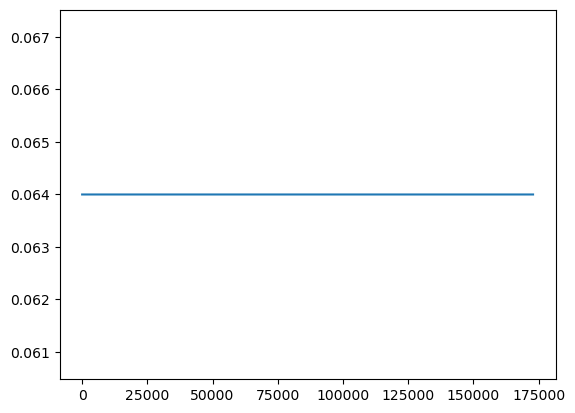

In [84]:
plt.plot(mir_data.sp_data['tau0'])